In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from functools import partial
from scipy.optimize import curve_fit
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D

In [2]:
df = pd.read_csv('example_options_history.csv')

In [3]:
# fixing a bought date
df_day = df[df['date'] == '2023-06-30']
df_day = df_day[['adj_close', 'div_yield', 'strike', 'expiration_days', 'call/put', 'best_bid', 'best_offer',
       'volume', 'implied_vol', 'delta', 'disc_rate', 'expiration']]
df_day =  df_day.drop_duplicates()

In [4]:
# drop the data with no bid
df_day = df_day[df_day['best_bid'] != 0]

In [5]:
# only ust OTM options
df_day = df_day[(df_day['strike'] >= df_day['adj_close']) & (df_day['call/put'] == 'C') | (df_day['strike'] <= df_day['adj_close']) & (df_day['call/put'] == 'P')]

In [6]:
# sort the dataframe, which is important
df_day= df_day.sort_values(by=['expiration_days', 'strike'])
df_day

,adj_close,div_yield,strike,expiration_days,call/put,best_bid,best_offer,volume,implied_vol,delta,disc_rate,expiration
329121,193.97,0.004795,148.0,7,P,0.01,0.02,147,0.712722,-0.002555,0.047162,2023-07-07
329137,193.97,0.004795,149.0,7,P,0.01,0.02,128,0.696531,-0.002611,0.047162,2023-07-07
329136,193.97,0.004795,150.0,7,P,0.01,0.02,3470,0.680424,-0.002669,0.047162,2023-07-07
329135,193.97,0.004795,155.0,7,P,0.01,0.02,755,0.601077,-0.003000,0.047162,2023-07-07
329134,193.97,0.004795,157.5,7,P,0.01,0.02,447,0.562097,-0.003195,0.047162,2023-07-07
...,...,...,...,...,...,...,...,...,...,...,...,...
327336,193.97,0.004795,270.0,903,C,10.60,11.00,3,0.213396,0.305605,0.063428,2025-12-19
327335,193.97,0.004795,280.0,903,C,8.00,9.00,6,0.206967,0.259506,0.063428,2025-12-19
327334,193.97,0.004795,290.0,903,C,6.65,8.50,31,0.211866,0.233492,0.063428,2025-12-19
327333,193.97,0.004795,300.0,903,C,5.60,5.95,61,0.204768,0.192622,0.063428,2025-12-19


In [7]:
def f(para, y, v):
    a, c, d = para
    return sum((a + d * y + c * np.sqrt(y ** 2 + 1) - v) ** 2)


# quasi_explicit with constraint modified
def gatheral_aux_func(para, dataframe):
    S = dataframe['adj_close'].iloc[0]
    T = dataframe['expiration_days'].iloc[0] / 365
    r = dataframe['disc_rate'].iloc[0]
    q = dataframe['div_yield'].iloc[0]
    F_T = S * np.exp((r - q) * T)
    x = np.log(dataframe['strike'] / F_T)
    w = T * dataframe['implied_vol'] ** 2
    m, sig = para
    y = (x - m) / sig
    cons=({'type': 'ineq', 'fun': lambda z: z[1] - abs(z[2])},
          {'type': 'ineq', 'fun': lambda z: 4 * sig - z[1] - abs(z[2])},
          {'type': 'ineq', 'fun': lambda z: z[0] + np.sqrt(abs(z[1] - abs(z[2])))},
           {'type': 'ineq', 'fun': lambda z: max(w) - z[0]})
    res = minimize(f, [0.1, 0.1, 0.1], args=(y, w), constraints = cons)
    return res.fun, res.x

def fit_svi(initial, dataframe):
    m0, sig0 = initial
    m, sig = minimize(lambda x: partial(gatheral_aux_func, dataframe=dataframe)(x)[0], [m0, sig0], method='Nelder-Mead').x
    _, para = gatheral_aux_func((m, sig), dataframe)
    a, c, d = para
    rho = d / c
    b = c / sig
    return a, b, rho, m, sig

In [9]:
dates = df_day['expiration'].unique()

In [10]:
# parameters from quasi-explicit modified method
quasi_para = []
for date in dates:
    df_curr = df_day[df_day['expiration'] == date]
    para = fit_svi((0.01, 0.2), df_curr)
    quasi_para.append(para)

In [11]:
# plot total variance vs log-moneyness
def plot_total_var(para, date, df):
    a, b, rho, m, sig = para
    df_curr = df[df['expiration'] == date]
    x = df_curr['strike']
    y = df_curr['implied_vol']
    S = df_curr['adj_close'].iloc[0]
    T = df_curr['expiration_days'].iloc[0] / 365
    r = df_curr['disc_rate'].iloc[0]
    q = df_curr['div_yield'].iloc[0]
    F_T = S * np.exp((r - q) * T)
    x_tilde = np.log(x / F_T)
    ans = a + b * (rho * (x_tilde - m) + np.sqrt((x_tilde - m) ** 2 + sig ** 2))
    plt.title('Total Variance for AAPL bought on 2023-06-30')
    plt.plot(x_tilde, ans, '-', label = date, linewidth=0.5)
    plt.xlabel('Log Moneyness k')
    plt.ylabel('Total Variance')
    plt.legend()

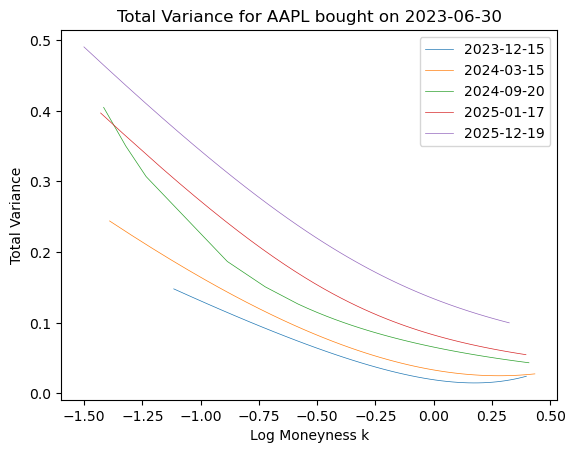

In [12]:
#list few of them so that the graph is not so dense
for date, para in list(zip(dates, quasi_para))[10::2]:
    plot_total_var(para, date, df_day)

In [15]:
def svi(para, x):
    a, b, rho, m, sig = para
    return a + b * (rho * (x - m) + np.sqrt((x - m) ** 2 + sig ** 2))

def svi_cross(df, sviGuess, penaltyFactor=100):
    expDates = np.unique(df['expiration_days'])
    nSlices = len(expDates)
    sviMatrix = []

    def sqDist(sviparams, S, K, T, r, q, tot):
        F_T = S * np.exp((r - q) * T)
        x = np.log(K / F_T)
        predict = svi(sviparams, x)
        return np.sum((tot - predict) ** 2)

    def sqDistN(sviparams, S, K, T, r, q, tot, idx):
        return sqDist(sviparams, S, K, T, r, q, tot) / sqDist(sviGuess[idx], S, K, T, r, q, tot)

    def crossPenalty(sviparams, penaltyFactor, low_K, high_K):
        # Compare with previous slice
        prev = [sviparams]
        prev.append(sviMatrix[-1])
        cPenalty = svi_check(prev, low_K, high_K)

        return cPenalty * penaltyFactor

    
    sviMatrix.append(sviGuess[-1])
    for idx in range(nSlices - 2, -1, -1):
        t = expDates[idx]
        df_curr = df[df['expiration_days'] == t]
        S = df_curr['adj_close'].iloc[0]
        r = df_curr['disc_rate'].iloc[0]
        q = df_curr['div_yield'].iloc[0]
        K = df_curr['strike']
        T = t / 365
        tot = df_curr['implied_vol'] ** 2 * T
        F_T = S * np.exp((r - q) * T)
        low_x = np.log((min(K) - 5) / F_T)
        high_x = np.log((max(K) - 5) / F_T)
        def penalty_func(sviparams, S, K, T, r, q, tot, idx, penaltyFactor, low_K, high_K):
            return sqDistN(sviparams, S, K, T, r, q, tot, idx) + crossPenalty(sviparams, penaltyFactor, low_K, high_K)

        fit = minimize(penalty_func, sviGuess[idx], args=(S, K, T, r, q, tot, idx, penaltyFactor, low_x, high_x), method='BFGS')
        sviMatrix.append(fit.x)

        if abs(fit.x[2]) > 1:  # Only send to L-BFGS-B if rho is outside the permitted range
            fit = minimize(penalty_func, sviGuess[idx], args=(S, K, T, r, q, tot, idx, penaltyFactor, low_x, high_x), method='L-BFGS-B', bounds=((-1000, 1000), (0, 100), (-1, 1), (-10, 10), (0.00000001, 100)))
            sviMatrix[-1] = fit.x
            
    sviMatrix.reverse()
    return sviMatrix

def svi_check(prev, l, r):
    x = np.linspace(l - 0.2, r + 0.2, 300)
    crossedness = 0
    for samplePoint in x: 
        sviShort = svi(prev[0], samplePoint)
        sviLong = svi(prev[1], samplePoint)
        crossedness = max(crossedness, sviShort - sviLong)
    return crossedness

In [31]:
res = svi_cross(df_day, np.array(quasi_para), 100)

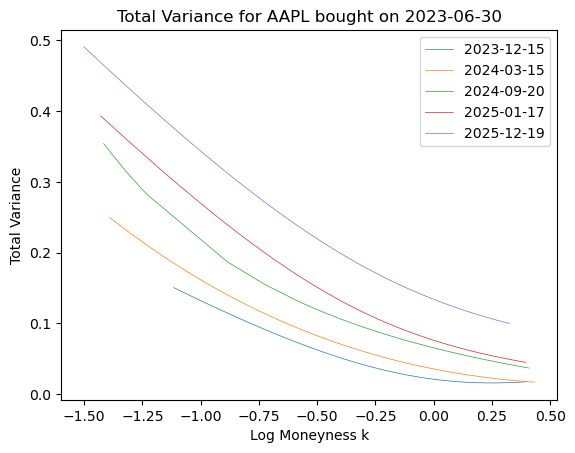

In [32]:
for date, para in list(zip(dates, res))[10::2]:
    plot_total_var(para, date, df_day)